### Load required packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
data

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


### Data preparation

Check if the missing values are presented in the features.
If there are missing values:
- For caterogiral features, replace them with 'NA'
- For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use <code>train_test_split</code> function for that with <code>random_state=1</code>.

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
data.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
data.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [6]:
data.fillna({'lead_source': 'NA', 'industry': 'NA', 'annual_income': 0, 'employment_status': 'NA', 'location': 'NA'}, inplace = True)
data.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
numerical_variables = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical_variables = ['lead_source', 'industry', 'employment_status', 'location']
target_variable = ['converted']

In [8]:
data_train_full, data_test = train_test_split(data, test_size = 0.2, train_size = 0.8, random_state = 1)
data_train, data_val = train_test_split(data_train_full, test_size = 0.25, random_state = 1)
data_train.shape, data_val.shape, data_test.shape

((876, 9), (293, 9), (293, 9))

In [9]:
# reset indices
data_train_full.reset_index(drop = True, inplace = True)
data_train.reset_index(drop = True, inplace = True)
data_val.reset_index(drop = True, inplace = True)
data_test.reset_index(drop = True, inplace = True)

In [10]:
# get target variables
y_train_full = data_train_full.converted.values
y_train = data_train.converted.values
y_val = data_val.converted.values
y_test = data_test.converted.values

In [11]:
# delete y from dataset -> this avoids accidentally adding variable to model
del data_train['converted']
del data_val['converted']
del data_test['converted']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front.

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [12]:
from sklearn.metrics import roc_auc_score

In [13]:
for variable in numerical_variables:
    variable_auc = roc_auc_score(y_train, data_train[variable])
    print(f"AUC for {variable} is {round(variable_auc, 3)}")

AUC for number_of_courses_viewed is 0.764
AUC for annual_income is 0.552
AUC for interaction_count is 0.738
AUC for lead_score is 0.614


In [14]:
for variable in numerical_variables:
    variable_auc = roc_auc_score(y_train, -data_train[variable])
    print(f"AUC for negated {variable} is {round(variable_auc, 3)}")

AUC for negated number_of_courses_viewed is 0.236
AUC for negated annual_income is 0.448
AUC for negated interaction_count is 0.262
AUC for negated lead_score is 0.386


### Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

<code>LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)</code>

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
train_dicts = data_train[categorical_variables + numerical_variables].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='lbfgs', C=1, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = data_val[categorical_variables + numerical_variables].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val_pred_prod = model.predict_proba(X_val)[:, 1]

val_auc = roc_auc_score(y_val, y_val_pred_prod)
val_auc

0.9200460166810468

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

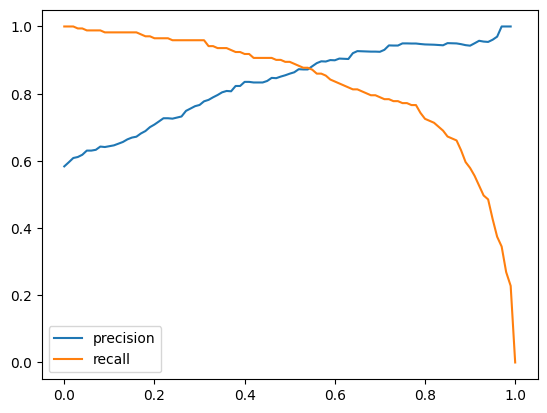

In [17]:
thresholds = np.arange(0, 1.01, 0.01)
true_positives = []
true_negatives = []
false_positives = []
false_negatives = []
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
for threshold in thresholds:
    predict_positive_threshold = (y_val_pred_prod >= threshold)
    predict_negative_threshold = (y_val_pred_prod < threshold)

    tp_threshold = (predict_positive_threshold & actual_positive).sum()
    tn_threshold = (predict_negative_threshold & actual_negative).sum()

    fp_threshold = (predict_positive_threshold & actual_negative).sum()
    fn_threshold = (predict_negative_threshold & actual_positive).sum()
    true_positives.append(tp_threshold)
    true_negatives.append(tn_threshold)
    false_positives.append(fp_threshold)
    false_negatives.append(fn_threshold)

threshold_df = pd.DataFrame({'threshold': thresholds,'true_positives': true_positives, 'true_negatives': true_negatives,
                            'false_positives': false_positives, 'false_negatives': false_negatives})

threshold_df['precision'] = threshold_df.true_positives/(threshold_df.true_positives + threshold_df.false_positives)
threshold_df['recall'] = threshold_df.true_positives/(threshold_df.true_positives + threshold_df.false_negatives)

plt.plot(threshold_df.threshold, threshold_df.precision, label = 'precision')
plt.plot(threshold_df.threshold, threshold_df.recall, label = 'recall')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
$$
F1 = 2 ⋅ \frac{P ⋅ R}{P + R}
$$

Where P is precision and  R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

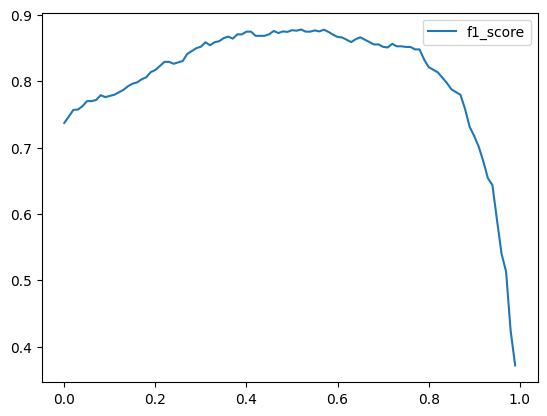

In [18]:
threshold_df['f1_score'] = 2 * (threshold_df.precision * threshold_df.recall)/(threshold_df.precision + threshold_df.recall)

plt.plot(threshold_df.threshold, threshold_df.f1_score, label = 'f1_score')
plt.legend()

In [19]:
threshold_df[threshold_df.f1_score == threshold_df.f1_score.max()]

,threshold,true_positives,true_negatives,false_positives,false_negatives,precision,recall,f1_score
52,0.52,151,100,22,20,0.872832,0.883041,0.877907


### Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

<code>KFold(n_splits=5, shuffle=True, random_state=1)</code>

- Iterate over different folds of <code>df_full_train</code>
- Split the data into train and validation
- Train the model on train with these parameters: <code>LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)</code>
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [20]:
from sklearn.model_selection import KFold

In [21]:
def k_fold_train(train_df, y_train, C=1, iter=1000):
    train_dicts = train_df[categorical_variables + numerical_variables].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=iter)
    model.fit(X_train, y_train)

    return dv, model

In [22]:
def k_fold_pred(test_df, dv, model):
    test_dicts = test_df[categorical_variables + numerical_variables].to_dict(orient='records')
    X_test = dv.transform(test_dicts)
    y_test_pred = model.predict_proba(X_test)[:, 1]

    return y_test_pred

In [32]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(data_train_full):
    train_df = data_train_full.iloc[train_idx]
    val_df = data_train_full.iloc[val_idx] 

    y_train = train_df.converted.values
    y_val = val_df.converted.values

    dv, model = k_fold_train(train_df, y_train)
    y_pred = k_fold_pred(val_df, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print(f"Average score {np.mean(scores)} and standard deviation {np.std(scores)}")

Average score 0.8221089148573075 and standard deviation 0.03580711942905165


### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: <code>[0.000001, 0.001, 1]</code>
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: <code> LogisticRegression(solver='liblinear', C=C, max_iter=1000) </code>
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [31]:
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(data_train_full):
        train_df = data_train_full.iloc[train_idx]
        val_df = data_train_full.iloc[val_idx] 

        y_train = train_df.converted.values
        y_val = val_df.converted.values

        dv, model = k_fold_train(train_df, y_train, C)
        y_pred = k_fold_pred(val_df, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(f"{C} average score {round(np.mean(scores), 3)} and standard deviation {round(np.std(scores), 3)}")

1e-06 average score 0.56 and standard deviation 0.024
0.001 average score 0.867 and standard deviation 0.029
1 average score 0.822 and standard deviation 0.036
